# <h1 align="center">COSC2753 - Machine Learning</h1>

<h2 align="center">Group Machine Learning Project</h2>

# TABLE OF CONTENT

[I. IMPORT NECESSARY LIBRARIES](#i-import-necessary-libraries)

[II. MODEL TRAINING: DISEASE CLASSIFICATION](#ii-model-training-disease-classification)

  - [1) Dataset Preprocessing](#1-data-preprocessing)

  - [2) Setup Global Variable](#2-setup-global-variables)

  - [3) Store Image in Generator](#3-store-image-in-generator)
  
  - [4) Baseline Models](#4-baseline-models)

  - [5) Model Selection and Tuning](#5-model-selection-and-tuning)

# I. IMPORT NECESSARY LIBRARIES

In [ ]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import random
import importlib
import pickle

import numpy as np
from PIL import Image

# Data preprocessing
from sklearn.model_selection import train_test_split

# Sklearn Library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Import custom libraries
import utils.visualizations as vi
import utils.preprocessing as pr
import utils.model_training as mt

importlib.reload(vi)
importlib.reload(pr)
importlib.reload(mt);

<module 'utils.model_training' from '/Users/vantai/RMIT/machine-learning/COSC2753-assignment-2/utils/model_training.py'>

## Import Tensorflow for TensorFlow ≤ 2.12

In [ ]:
# # Deep learning libraries
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,Activation,GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.initializers import GlorotUniform
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.models import load_model

## Using Keras for Keras 3.x with TensorFlow ≥ 2.13

In [36]:
# Deep learning libraries
import tensorflow as tf
from keras import Sequential, layers, models, Input
from keras.regularizers import l2
from keras.layers import (
    Dense,
    Flatten,
    Dropout,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.initializers import GlorotUniform
from keras.models import load_model

# II. MODEL TRAINING: DISEASE CLASSIFICATION

To ensure that the results are stable for multiple run time, we setup the seed for dataset

In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1) Data Preprocessing

In [3]:
df = pd.read_csv("./inputs/training_df.csv")

In [4]:
# Define random_state
random_state = 42

train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)

vi.print_header("Train Dataset shape")
print("Number of Rows: ", train_df.shape[0])
print("Number of Columns: ", train_df.shape[1])

vi.print_header("Validation Dataset Shape")
print("Number of Rows: ", val_df.shape[0])
print("Number of Columns: ", val_df.shape[1])

+-----------------------------------------+
|           TRAIN DATASET SHAPE           |
+-----------------------------------------+
Number of Rows:  8325
Number of Columns:  5
+----------------------------------------------+
|           VALIDATION DATASET SHAPE           |
+----------------------------------------------+
Number of Rows:  2082
Number of Columns:  5


## 2) Setup global variables

`OUTPUT_CLASSES = 10`
This defines the number of output classes. Since the dataset contains 10 categories (9 disease types and 1 healthy class), the model must have 10 output units to predict the correct class for each image.

`BATCH_SIZE = 32`
The batch size is set to 32 as a common standard that balances model training efficiency and computational resources. It allows for reasonable updates while managing memory usage.

`INPUT_DIM = (64, 64, 3)`
The input dimension is 64x64 pixels with 3 color channels (RGB). This size is a standard choice, balancing computational cost with sufficient image detail for the task.



In [5]:
OUTPUT_CLASSES = 10
BATCH_SIZE = 32
INPUT_DIM = (128,128,3)

## 3) Store image in generator

The `ImageDataGenerator` is used to rescale pixel values to a [0, 1] range, which is a standard preprocessing step for neural networks. The `data_format='channels_last'` ensures the data is structured with color channels last, as required by many deep learning frameworks.

The `flow_from_dataframe` method is used because the image paths and labels are stored in a DataFrame. It makes it easy to load the images along with their labels directly from the DataFrame, allowing for efficient batch processing during training.

The images are resized to 64x64 pixels to standardize the input size for the model. This resolution is a common trade-off between detail and computational efficiency for image classification tasks.

The `class_mode='categorical'` is used because the task involves multi-class classification. This ensures the labels are one-hot encoded, suitable for a multi-class output.

The fixed `seed=42` is set to ensure reproducibility, making the data shuffling consistent across different runs of the model.

In [26]:
train_df["label"] = train_df["label"].astype("str")
val_df["label"] = val_df["label"].astype("str")

train_datagen = ImageDataGenerator(rescale=1.0 / 255, data_format="channels_last")
val_datagen = ImageDataGenerator(rescale=1.0 / 255, data_format="channels_last")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="",
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="",
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED,
)

Found 8325 validated image filenames belonging to 10 classes.
Found 2082 validated image filenames belonging to 10 classes.


## 4) Baseline Models

In this baseline models comparison, we set the average epochs for all models to be 25, this is to ensure the fairness between all models and for clearer visualizations. Moreover, we compiled all models with `Adam` optimizer and the loss function of `categorical_crossentropy`. 

- `Adaptive Learning Rates`: It helps to adapt the learning rate for each parameter in the model. This is highly beneficial as different parameters might require different update magnitudes to learn effectively. With combination of `categorical_crossentropy`, we can be more effective when it comes to dealing with complex, high-dimensional loss landscapes. 
- `Momentum Integration`: It incorporates past gradients, which helps to accelerate the optimization process in relavant direction and dampen oscillations.
- `Bias Correction`: Adam includes a bias correction for its initial zero-set estimates. This counteracts their tendency to be pulled towards zero early in training, leading to more stable updates from the outset.
- `Computing efficiency`: The optimizer also uses less memory and still provides a good results. Also, it also has a good default settinsg, therefore, with less configuration, we can still get a good results.
- `Effective with large dataset`: Adam works well for large-scale problems, whether that means lots of data or many model parameters. This makes it a good fit for common situations like training models that need to distinguish between multiple classes.

When paired with `categorical_crossentropy`, the Adam optimizer effectively leverages its aforementioned advantages to significantly boost the model's performance in multi-class classification tasks.


### 4.1) MLP

The `MLP model` is a simple feedforward neural network with three hidden layers. The architecture is as follows:
- **Input Layer**: Accepts the input images, flattened to a 1D array.
- **Hidden Layer 1**: 1024 neurons with `ReLU activation`
- **Hidden Layer 2**: 512 neurons with `ReLU activation` 
- **Hidden Layer 3**: 256 neurons with `ReLU activation`
- **Output Layer**: 10 neurons with `softmax` activation for multi-class classification.

In [10]:
mlp_baseline = Sequential(
    [
        # Input layer and flatten
        Flatten(input_shape=INPUT_DIM),
        Dense(1024, activation="relu"),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        # Output layer (10 classes)
        Dense(10, activation="softmax"),
    ]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
mlp_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,991,370 (194.52 MB)

 Trainable params: 50,991,370 (194.52 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile model
mlp_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [83]:
mlp_history = mlp_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1,
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.1836 - loss: 3.6300 - val_accuracy: 0.3007 - val_loss: 1.9949
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.3004 - loss: 1.9582 - val_accuracy: 0.3650 - val_loss: 1.8129
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.3696 - loss: 1.7899 - val_accuracy: 0.3453 - val_loss: 1.8796
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.4321 - loss: 1.6651 - val_accuracy: 0.4135 - val_loss: 1.7481
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.4689 - loss: 1.5486 - val_accuracy: 0.4822 - val_loss: 1.5406
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.5709 - loss: 1.2887 - val_accuracy: 0.4827 - val_loss: 1.5804
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.5939 - loss: 1.1976 - val_accuracy: 0.5235 - val_loss: 1.4857
Epoch 8/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.6470 - loss: 1

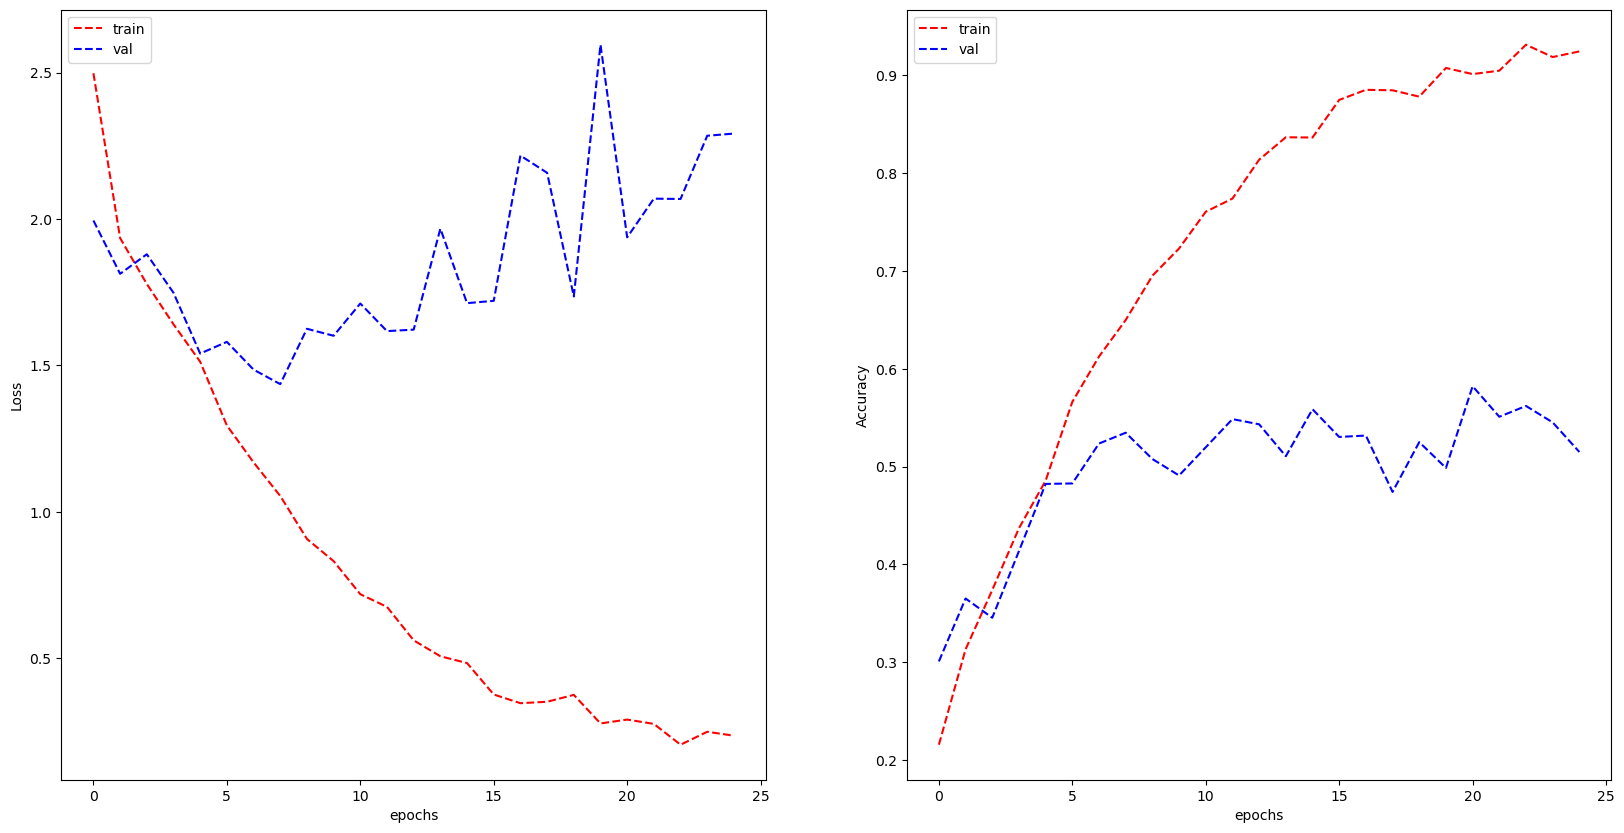

In [ ]:
mt.plot_learning_curve(
    mlp_history.history["loss"],
    mlp_history.history["val_loss"],
    mlp_history.history["accuracy"],
    mlp_history.history["val_accuracy"],
)

### 4.2) CNN

CNNs are particularly effective for image classification, making them a strong choice for this project, which involves classifying paddy plant images into disease categories or a healthy class. The reasons for using CNNs include:

- **Automatic Feature Extraction**: CNNs learn relevant features from raw pixel data, eliminating the need for manual feature engineering, and making them ideal for complex image tasks like classifying plant diseases.
  
- **Spatial Awareness**: CNNs preserve the spatial structure of images, allowing them to detect important patterns such as disease symptoms in plant images.

- **Efficiency**: Through convolution and pooling layers, CNNs reduce the number of parameters, making the model computationally efficient while still capturing essential details from images.

- **Proven Performance**: CNNs have consistently outperformed other models in image classification tasks and are the standard approach for processing visual data.

In short, CNNs are the best choice for this task due to their ability to automatically extract features, process images efficiently, and deliver high performance for classification tasks.


In [17]:
cnn_baseline = Sequential(
    [
        Conv2D(16, (3, 3), activation="relu", input_shape=INPUT_DIM),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1024, activation="relu"),
        Dense(128, activation="relu"),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
cnn_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    12,846,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002,154 (49.60 MB)

 Trainable params: 13,002,154 (49.60 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
cnn_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
cnn_history = cnn_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1,
)

Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 131ms/step - accuracy: 0.2316 - loss: 2.0900 - val_accuracy: 0.4011 - val_loss: 1.7405
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - accuracy: 0.4807 - loss: 1.5396 - val_accuracy: 0.5759 - val_loss: 1.2474
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 30s 116ms/step - accuracy: 0.6476 - loss: 1.0919 - val_accuracy: 0.6643 - val_loss: 1.0139
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.7639 - loss: 0.7406 - val_accuracy: 0.7358 - val_loss: 0.8522
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.8510 - loss: 0.4770 - val_accuracy: 0.7815 - val_loss: 0.7102
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.9120 - loss: 0.2916 - val_accuracy: 0.8084 - val_loss: 0.6869
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.9443 - loss: 0.1779 - val_accuracy: 0.8329 - val_loss: 0.6168
Epoch 8/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.9609 - loss: 0

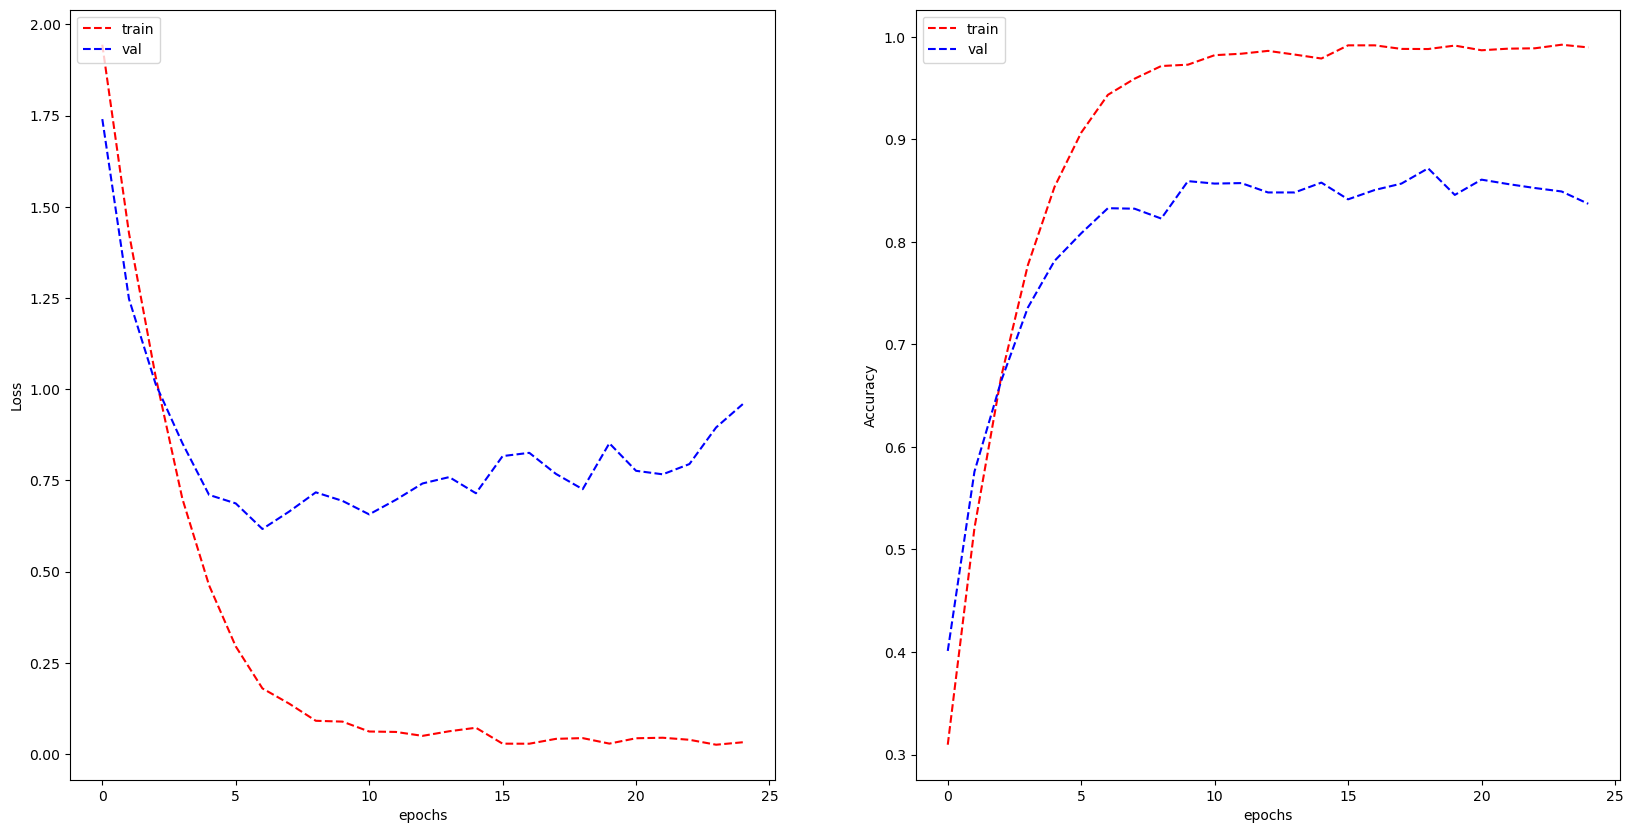

In [ ]:
mt.plot_learning_curve(
    cnn_history.history["loss"],
    cnn_history.history["val_loss"],
    cnn_history.history["accuracy"],
    cnn_history.history["val_accuracy"],
    metric_name="Accuracy",
)

### 4.3) KNN and CNN + SVC Model

Trước khi train CNN và SVC Model thì phải qua bước extractor... xong rồi mơi train ở dưới


The model is a combination of a Convolutional Neural Network (CNN) and a K-Nearest Neighbors (KNN) classifier. The CNN is used for feature extraction, while the KNN classifier is used for the final classification.

In [23]:
# Function to extract features using the model
def extract_features(feature_extractor, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]  # Get batch from generator
        batch_features = feature_extractor.predict(
            batch_images, verbose=0
        )  # Get features from CNN
        features.append(batch_features)
        labels.append(batch_labels)

        # If it's the last batch, break the loop
        if len(features) * generator.batch_size >= generator.samples:
            break

    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)

    return features, labels

In [24]:
# Create the GlorotUniform initializer with a seed
initializer = GlorotUniform(seed=SEED)
# Define the feature extraction part
feature_extractor = Sequential(
    [
        Conv2D(
            16,
            (3, 3),
            activation="relu",
            input_shape=INPUT_DIM,
            kernel_initializer=initializer,
        ),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
    ]
)

for layer in feature_extractor.layers:
    if hasattr(layer, "kernel_initializer"):
        layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape))

# Compile the feature extractor
feature_extractor.compile(
    optimizer="adam", loss=None
)  # No loss needed for feature extraction

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Extract features and labels from the train and validation generators
train_features, train_labels = extract_features(feature_extractor, train_generator)
val_features, val_labels = extract_features(feature_extractor, val_generator)

# Flatten the labels to 1D (from one-hot encoding) for KNN
train_labels_flat = np.argmax(train_labels, axis=1)
val_labels_flat = np.argmax(val_labels, axis=1)

#### KNN Model

In [ ]:
# Train KNN classifier
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(train_features, train_labels_flat)

# Make predictions on the validation set
knn_train_pred = knn_baseline.predict(train_features)
# Make predictions on the validation set
knn_val_pred = knn_baseline.predict(val_features)

In [134]:
# Evaluate the model accuracy
knn_train_accuracy = accuracy_score(train_labels_flat, knn_train_pred)
print(f"Train accuracy of the CNN + KNN model: {knn_train_accuracy * 100:.2f}%")

# Evaluate the model accuracy
knn_val_accuracy = accuracy_score(val_labels_flat, knn_val_pred)
print(f"Validation accuracy of the CNN + KNN model: {knn_val_accuracy * 100:.2f}%")

Train accuracy of the CNN + KNN model: 87.14%
Validation accuracy of the CNN + KNN model: 76.61%


#### CNN + SVC Models

The model is a combination of a Convolutional Neural Network (CNN) and a Support Vector Classifier (SVC). The CNN is used for feature extraction, while the SVC classifier is used for the final classification.

In [135]:
# Train an SVM classifier on the extracted features
svc_classifier = SVC(kernel="rbf", C=1.0, gamma="scale")
svc_classifier.fit(train_features, train_labels_flat)

# Make predictions on the test set
svc_val_pred = svc_classifier.predict(val_features)
svc_train_pred = svc_classifier.predict(train_features)

In [138]:
# Evaluate the SVM model
svc_train_accuracy = accuracy_score(train_labels_flat, svc_train_pred)
print(f"Train Accuracy of the CNN + SVM model: {svc_train_accuracy * 100:.2f}%")

svc_val_accuracy = accuracy_score(val_labels_flat, svc_val_pred)
print(f"Validation Accuracy of the CNN + SVM model: {svc_val_accuracy * 100:.2f}%")

Train Accuracy of the CNN + SVM model: 49.81%
Validation Accuracy of the CNN + SVM model: 46.83%


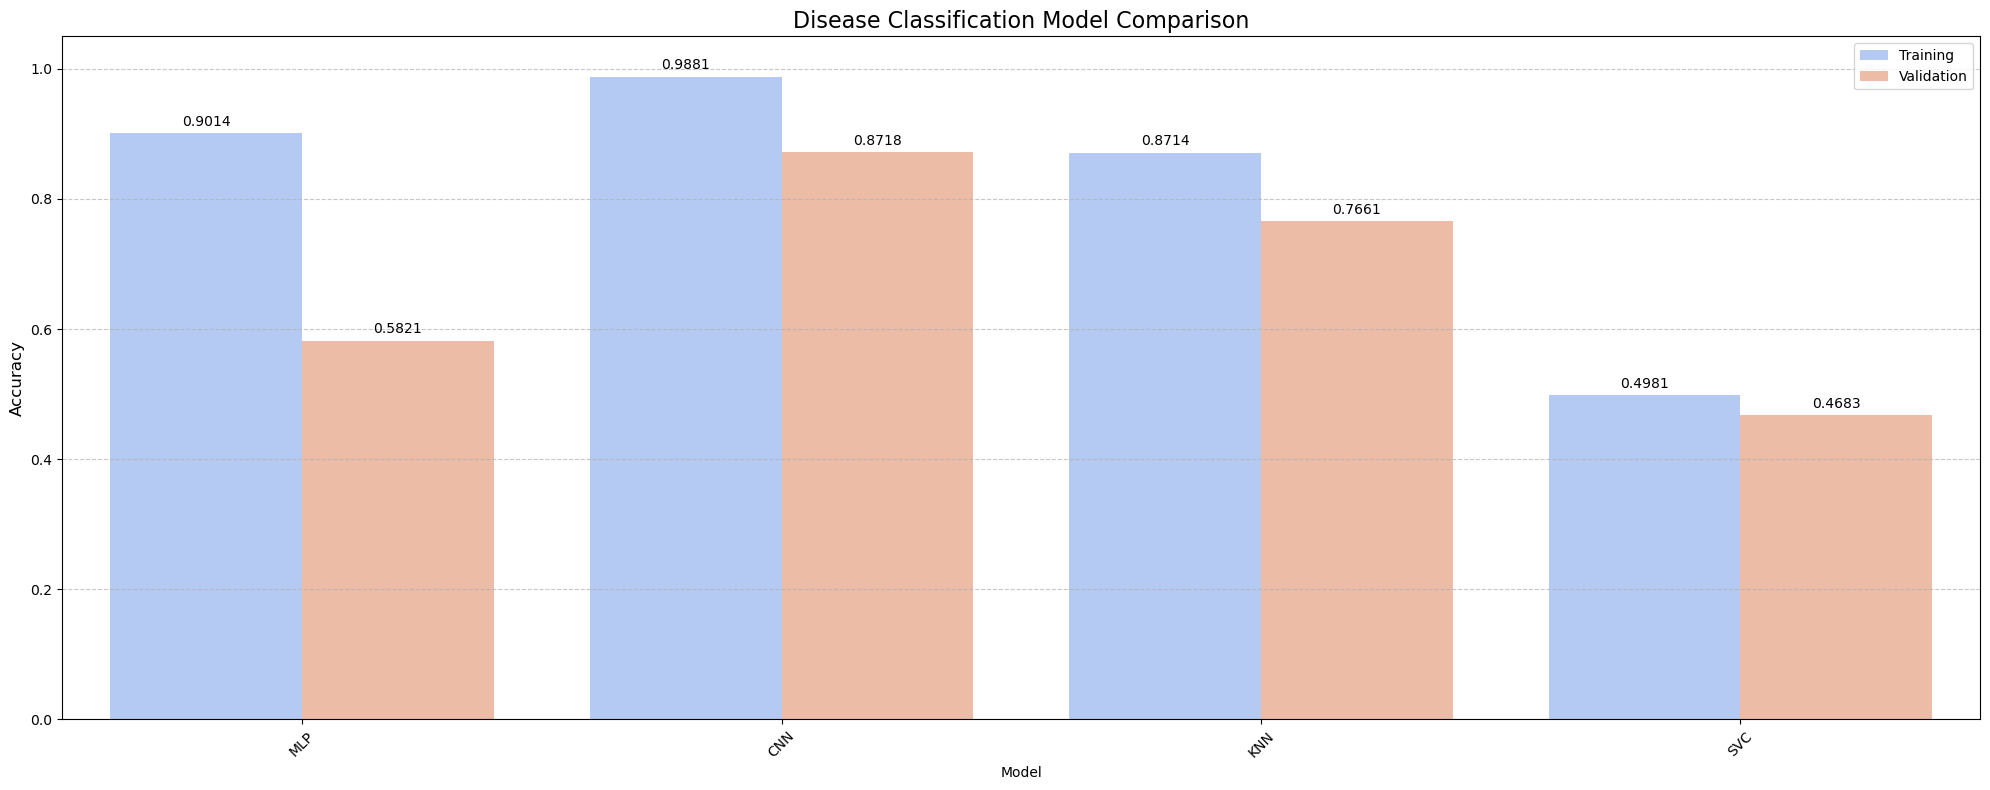

In [ ]:
# Get MLP accuracies
best_mlp_epoch = np.argmax(mlp_history.history["val_accuracy"])
mlp_val_accuracy = mlp_history.history["val_accuracy"][best_mlp_epoch]
mlp_train_accuracy = mlp_history.history["accuracy"][best_mlp_epoch]

# Get CNN accuracies
best_cnn_epoch = np.argmax(cnn_history.history["val_accuracy"])
cnn_val_accuracy = cnn_history.history["val_accuracy"][best_cnn_epoch]
cnn_train_accuracy = cnn_history.history["accuracy"][best_cnn_epoch]

model_results = {
    "MLP": (mlp_train_accuracy, mlp_val_accuracy),
    "CNN": (cnn_train_accuracy, cnn_val_accuracy),
    "KNN": (knn_train_accuracy, knn_val_accuracy),
    "SVC": (svc_train_accuracy, svc_val_accuracy),
}

mt.plot_model_results(
    model_results, "Disease Classification Model Comparison", figsize=(20, 8)
)

**Oberservation**: The CNN is the best model. Although the CNN is best model with high accuracy on the training set, its accuracy on the validation set is not good as on the training set. For that reason, this model is overfitting. We need to apply some techniques to reduce overfitting.

## 5) Model Selection and Tuning

From the results of the baseline models, we can see that the CNN model is the best model with high accuracy on the training set. However, its accuracy on the validation set is not good as on the training set. For that reason, this model is overfitting. We need to apply some techniques to ehnace the model performance and reduce overfitting.
- Adding blocks (VGG block)
- Adding dropout layers
- Applying Early Stopping

In [34]:
def build_vgg_model(l2_strength):
    return Sequential(
        [
            # Block 1
            Conv2D(
                32,
                (3, 3),
                padding="same",
                kernel_regularizer=l2_strength,
                input_shape=INPUT_DIM,
            ),
            BatchNormalization(),
            Activation("relu"),
            Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2_strength),
            BatchNormalization(),
            Activation("relu"),
            MaxPooling2D((2, 2)),
            # Block 2
            Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2_strength),
            BatchNormalization(),
            Activation("relu"),
            Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2_strength),
            BatchNormalization(),
            Activation("relu"),
            MaxPooling2D((2, 2)),
            # Block 3
            Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2_strength),
            BatchNormalization(),
            Activation("relu"),
            MaxPooling2D((2, 2)),
            # Global Pooling and Dense Layers
            GlobalAveragePooling2D(),
            Dense(128, activation="relu", kernel_regularizer=l2_strength),
            Dropout(0.3),
            Dense(OUTPUT_CLASSES, activation="softmax"),
        ]
    )

In [ ]:
# # Initialize tracking variables
# lambda_parameters = [0.0001, 0.001, 0.01, 0.1]
# best_model_found = None
# best_val_accuracy = 0
# best_lambda = None
# best_model_path = None

# for para_l2_strength in lambda_parameters:
#     print(f"\nTraining model with L2 regularization lambda = {para_l2_strength}")

#     vgg_model = build_vgg_model(l2(para_l2_strength))
#     vgg_model.compile(
#         optimizer=Adam(learning_rate=0.0001),
#         loss="categorical_crossentropy",
#         metrics=["accuracy"],
#     )

#     early_stopping = EarlyStopping(
#         monitor="val_accuracy", patience=15, restore_best_weights=True
#     )

#     history = vgg_model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=25,
#         callbacks=[early_stopping],
#         verbose=1,
#     )

#     current_val_accuracy = max(history.history["val_accuracy"])

#     if current_val_accuracy > best_val_accuracy:
#         best_val_accuracy = current_val_accuracy
#         best_lambda = para_l2_strength
#         best_model_found = vgg_model
#         best_model_path = f"./models/vgg_best_model_lambda_{best_lambda}.h5"
#         best_history = history.history

#         print(
#             f"*** New best model found with lambda={para_l2_strength}, val_accuracy: {current_val_accuracy:.4f} ***\n"
#         )

#         vgg_model.save(best_model_path)
#     else:
#         print(
#             f"Model with lambda={para_l2_strength} (val_acc: {current_val_accuracy:.4f}) did not improve over current best (val_acc: {best_val_accuracy:.4f})\n"
#         )



Training model with L2 regularization lambda = 0.0001
Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 140s 530ms/step - accuracy: 0.2345 - loss: 2.2397 - val_accuracy: 0.2094 - val_loss: 2.3040
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 133s 509ms/step - accuracy: 0.3728 - loss: 1.8515 - val_accuracy: 0.2728 - val_loss: 2.0642
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 132s 504ms/step - accuracy: 0.4269 - loss: 1.7152 - val_accuracy: 0.4183 - val_loss: 1.6717
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 478ms/step - accuracy: 0.4581 - loss: 1.6264 - val_accuracy: 0.3194 - val_loss: 1.9486
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 130s 498ms/step - accuracy: 0.4825 - loss: 1.5731 - val_accuracy: 0.5019 - val_loss: 1.5347
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 132s 505ms/step - accuracy: 0.5113 - loss: 1.4722 - val_accuracy: 0.5235 - val_loss: 1.4711
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 129s 494ms/step - accuracy: 0.5339 - loss: 1.4239 - val_accuracy: 0.4976 - val_loss: 1.5140
Epoch 8/25
261/261 ━━

*** New best model found with lambda=0.0001, val_accuracy: 0.6955 ***


Training model with L2 regularization lambda = 0.001
Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 118s 444ms/step - accuracy: 0.2211 - loss: 2.5731 - val_accuracy: 0.1427 - val_loss: 2.6453
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 116s 443ms/step - accuracy: 0.3466 - loss: 2.2049 - val_accuracy: 0.2012 - val_loss: 2.7129
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 116s 443ms/step - accuracy: 0.3885 - loss: 2.0810 - val_accuracy: 0.4083 - val_loss: 2.0006
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 118s 453ms/step - accuracy: 0.4381 - loss: 1.9560 - val_accuracy: 0.4486 - val_loss: 1.9390
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 119s 454ms/step - accuracy: 0.4712 - loss: 1.8638 - val_accuracy: 0.5106 - val_loss: 1.7947
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 116s 444ms/step - accuracy: 0.5000 - loss: 1.8013 - val_accuracy: 0.5163 - val_loss: 1.7940
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 122s 467ms/step - accuracy: 0.5234 - loss: 

*** New best model found with lambda=0.01, val_accuracy: 0.7426 ***


Training model with L2 regularization lambda = 0.1
Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 117s 442ms/step - accuracy: 0.2040 - loss: 32.4455 - val_accuracy: 0.1700 - val_loss: 20.0291
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 441ms/step - accuracy: 0.3320 - loss: 17.2205 - val_accuracy: 0.2161 - val_loss: 11.8521
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 440ms/step - accuracy: 0.3987 - loss: 10.2698 - val_accuracy: 0.3598 - val_loss: 7.6893
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 114s 438ms/step - accuracy: 0.4384 - loss: 6.8143 - val_accuracy: 0.3300 - val_loss: 5.6769
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 114s 438ms/step - accuracy: 0.4621 - loss: 4.9238 - val_accuracy: 0.4097 - val_loss: 4.2297
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 439ms/step - accuracy: 0.4951 - loss: 3.7794 - val_accuracy: 0.5053 - val_loss: 3.2948
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 117s 449ms/step - accuracy: 0.5198 - loss:

NameError: name 'pickle' is not defined

In [ ]:
# # Save best model's history
# history_path = f"./models/history_lambda_{best_lambda}.pkl"
# with open(history_path, "wb") as f:
#     pickle.dump(best_history, f)

# print(f"Best lambda: {best_lambda}")
# print(f"Best model saved at: {best_model_path}")
# print(f"History saved at: {history_path}")

In [ ]:
# Initialize tracking variables
lambda_parameters = [0.0001, 0.001, 0.01, 0.1]
best_model_found = None
best_val_accuracy = 0
best_lambda = None
best_model_path = None

for para_l2_strength in lambda_parameters:
    print(f"\nTraining model with L2 regularization lambda = {para_l2_strength}")

    vgg_model = build_vgg_model(l2(para_l2_strength))
    vgg_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    early_stopping = EarlyStopping(
        monitor="val_accuracy", patience=15, restore_best_weights=True
    )

    history = vgg_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=[early_stopping],
        verbose=1,
    )

    current_val_accuracy = max(history.history["val_accuracy"])

    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        best_lambda = para_l2_strength
        best_model_found = vgg_model
        best_model_path = f"./models/vgg_best_model_lambda_{best_lambda}.h5"
        best_history = history.history

        print(
            f"*** New best model found with lambda={para_l2_strength}, val_accuracy: {current_val_accuracy:.4f} ***\n"
        )

        vgg_model.save(best_model_path)
    else:
        print(
            f"Model with lambda={para_l2_strength} (val_acc: {current_val_accuracy:.4f}) did not improve over current best (val_acc: {best_val_accuracy:.4f})\n"
        )

# Save best model's history
history_path = f"./models/history_lambda_{best_lambda}.pkl"
with open(history_path, "wb") as f:
    pickle.dump(best_history, f)

print(f"Best lambda: {best_lambda}")
print(f"Best model saved at: {best_model_path}")
print(f"History saved at: {history_path}")


Training model with L2 regularization lambda = 0.0001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.1671 - loss: 2.2685 - val_accuracy: 0.3165 - val_loss: 2.0581
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.2815 - loss: 2.0873 - val_accuracy: 0.4145 - val_loss: 1.8269
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.3713 - loss: 1.8812 - val_accuracy: 0.4534 - val_loss: 1.6043
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.4285 - loss: 1.6991 - val_accuracy: 0.5552 - val_loss: 1.4226
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.5033 - loss: 1.4974 - val_accuracy: 0.6239 - val_loss: 1.2469
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.5817 - loss: 1.2980 - val_accuracy: 0.6724 - val_loss: 1.1153
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.6327 - loss: 1.1346 - val_accuracy: 0.7358 - val_loss: 0.9122
Epoch 8/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.6997 - loss: 0.9335 - val_accu

*** New best model found with lambda=0.0001, val_accuracy: 0.8871 ***


Training model with L2 regularization lambda = 0.001
Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.1686 - loss: 2.6939 - val_accuracy: 0.3381 - val_loss: 2.3326
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.2719 - loss: 2.3531 - val_accuracy: 0.3525 - val_loss: 2.0375
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.3471 - loss: 2.0913 - val_accuracy: 0.4558 - val_loss: 1.8226
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.4115 - loss: 1.9143 - val_accuracy: 0.5207 - val_loss: 1.6366
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.4657 - loss: 1.7077 - val_accuracy: 0.5812 - val_loss: 1.4467
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.5305 - loss: 1.5482 - val_accuracy: 0.6671 - val_loss: 1.2781
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.5968 - loss: 1.3607 - val_accuracy

In [ ]:
vi.print_header("Training Results")
print(f"Best L2 regularization lambda: {best_lambda}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

+--------------------------------------+
|           TRAINING RESULTS           |
+--------------------------------------+
Best L2 regularization lambda: 0.0001
Best validation accuracy: 0.8871


In [ ]:
best_vgg_model = build_vgg_model(l2(0.0001))
best_vgg_model.compile(
        optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"]
    )
early_stopping = EarlyStopping(
        monitor="val_accuracy", patience=15, restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    "./models/best_vgg_model.h5", monitor="val_loss", save_best_only=True, verbose=1
)
callbacks = [early_stopping, model_checkpoint]
history_vgg = best_vgg_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=[callbacks],
        verbose=1,
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1553 - loss: 2.2862
Epoch 1: val_loss improved from inf to 2.04754, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.1555 - loss: 2.2860 - val_accuracy: 0.3295 - val_loss: 2.0475
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2802 - loss: 2.0730
Epoch 2: val_loss improved from 2.04754 to 1.83665, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.2803 - loss: 2.0728 - val_accuracy: 0.3727 - val_loss: 1.8367
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3583 - loss: 1.8846
Epoch 3: val_loss improved from 1.83665 to 1.58728, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.3584 - loss: 1.8844 - val_accuracy: 0.4472 - val_loss: 1.5873
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4248 - loss: 1.7051
Epoch 4: val_loss improved from 1.58728 to 1.43863, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.4248 - loss: 1.7050 - val_accuracy: 0.5255 - val_loss: 1.4386
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4865 - loss: 1.5144
Epoch 5: val_loss improved from 1.43863 to 1.26589, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.4865 - loss: 1.5144 - val_accuracy: 0.5908 - val_loss: 1.2659
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5548 - loss: 1.3538
Epoch 6: val_loss improved from 1.26589 to 1.13987, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.5548 - loss: 1.3537 - val_accuracy: 0.6700 - val_loss: 1.1399
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6109 - loss: 1.2073
Epoch 7: val_loss improved from 1.13987 to 0.97332, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.6110 - loss: 1.2073 - val_accuracy: 0.7195 - val_loss: 0.9733
Epoch 8/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6643 - loss: 1.0449
Epoch 8: val_loss improved from 0.97332 to 0.87272, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.6644 - loss: 1.0448 - val_accuracy: 0.7435 - val_loss: 0.8727
Epoch 9/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7088 - loss: 0.8999
Epoch 9: val_loss improved from 0.87272 to 0.82092, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.7088 - loss: 0.8999 - val_accuracy: 0.7776 - val_loss: 0.8209
Epoch 10/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7553 - loss: 0.7878
Epoch 10: val_loss improved from 0.82092 to 0.77954, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.7553 - loss: 0.7878 - val_accuracy: 0.7743 - val_loss: 0.7795
Epoch 11/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7772 - loss: 0.6873
Epoch 11: val_loss improved from 0.77954 to 0.66512, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.7772 - loss: 0.6872 - val_accuracy: 0.8156 - val_loss: 0.6651
Epoch 12/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8180 - loss: 0.5801
Epoch 12: val_loss did not improve from 0.66512
261/261 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.8180 - loss: 0.5802 - val_accuracy: 0.8271 - val_loss: 0.6712
Epoch 13/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8267 - loss: 0.5524
Epoch 13: val_loss improved from 0.66512 to 0.65215, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.8267 - loss: 0.5523 - val_accuracy: 0.8160 - val_loss: 0.6522
Epoch 14/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8491 - loss: 0.4812
Epoch 14: val_loss improved from 0.65215 to 0.61202, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.8492 - loss: 0.4811 - val_accuracy: 0.8468 - val_loss: 0.6120
Epoch 15/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8733 - loss: 0.4188
Epoch 15: val_loss improved from 0.61202 to 0.58061, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.8733 - loss: 0.4189 - val_accuracy: 0.8573 - val_loss: 0.5806
Epoch 16/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8778 - loss: 0.4023
Epoch 16: val_loss improved from 0.58061 to 0.53843, saving model to ./models/best_vgg_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.8778 - loss: 0.4022 - val_accuracy: 0.8684 - val_loss: 0.5384
Epoch 17/25
Epoch 17/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8954 - loss: 0.3554
Epoch 17: val_loss did not improve from 0.53843
261/261 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.8954 - loss: 0.3553 - val_accuracy: 0.8612 - val_loss: 0.5811
Epoch 18/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9085 - loss: 0.3069
Epoch 18: val_loss did not improve from 0.53843
261/261 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9085 - loss: 0.3069 - val_accuracy: 0.8655 - val_loss: 0.5469
Epoch 19/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9228 - loss: 0.2736
Epoch 19: val_loss did not improve from 0.53843
261/261 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.9228 - loss: 0.2736 - val_accuracy: 0.8665 - val_loss: 0.5517
Epoch 20/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9305 - loss: 0.2623
Epoch 20: val_loss did not i

In [35]:
best_vgg_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,100,960 (198.75 MB)

 Trainable params: 17,366,986 (66.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,733,974 (132.50 MB)

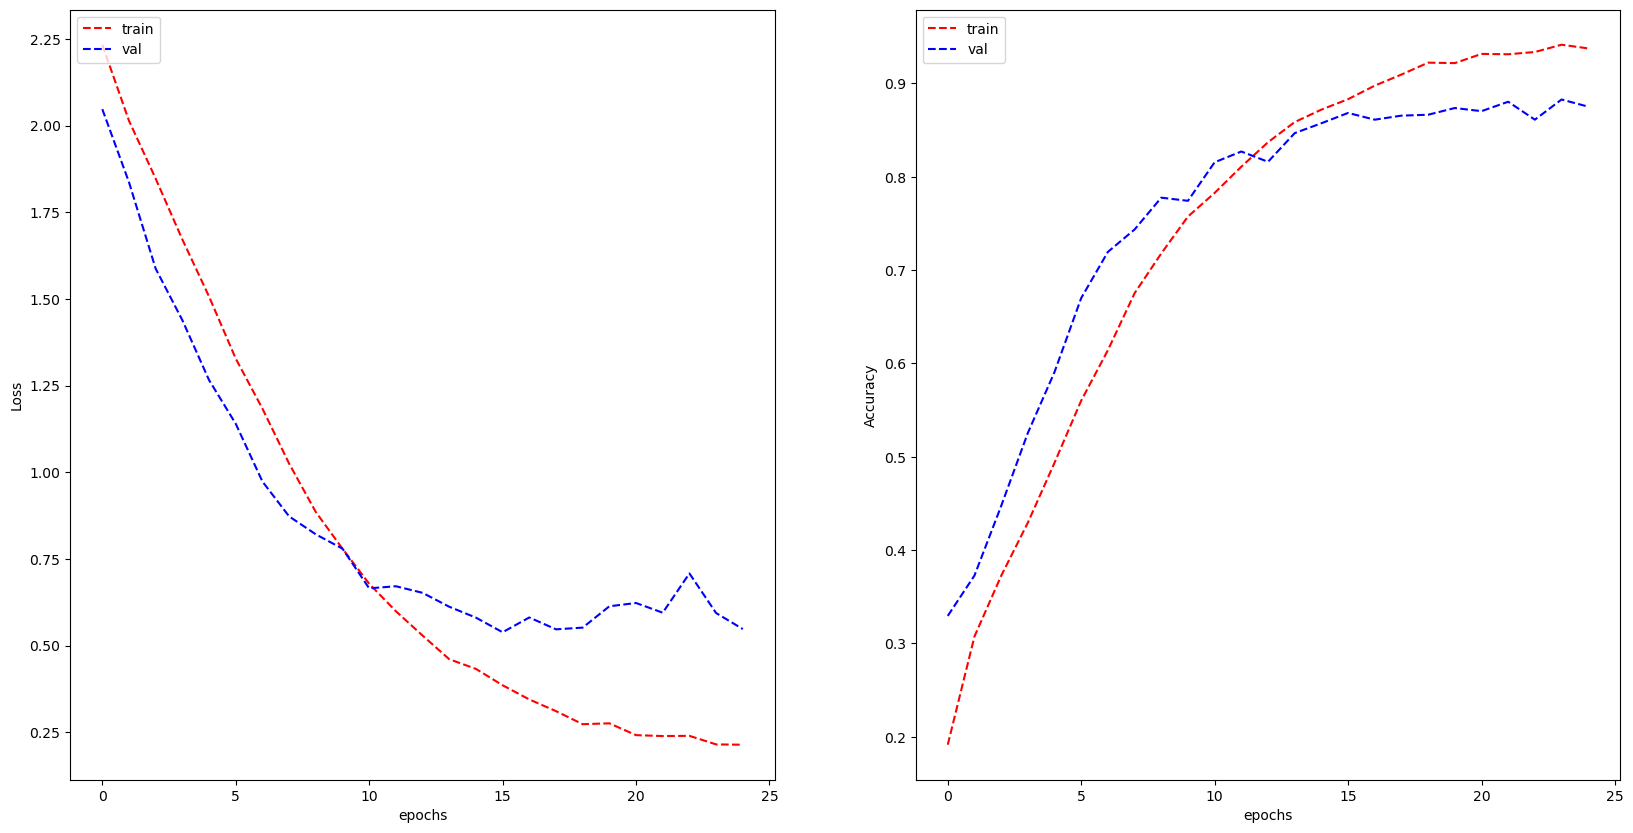

In [ ]:
mt.plot_learning_curve(
    history_vgg.history['loss'], history_vgg.history['val_loss'],
    history_vgg.history['accuracy'], history_vgg.history['val_accuracy'],
    metric_name='Accuracy'
)

In [30]:
model_path = "./models/best_vgg_model.h5"

In [31]:
try:
    loaded_best_model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

Model loaded successfully from ./models/best_vgg_model.h5


In [32]:
train_loss, train_accuracy = loaded_best_model.evaluate(train_generator, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

val_loss, val_accuracy = loaded_best_model.evaluate(val_generator, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Loss: 0.1058
Training Accuracy: 0.9868
Validation Loss: 0.5384
Validation Accuracy: 0.8684


In [26]:
train_loss, train_accuracy = loaded_best_model.evaluate(train_generator, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

val_loss, val_accuracy = loaded_best_model.evaluate(val_generator, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training Loss: 0.1058
Training Accuracy: 0.9868
Validation Loss: 0.5384
Validation Accuracy: 0.8684


In [27]:
# --- Predict on the Training Set ---
print("Predicting on the training set...")
raw_predictions_train = loaded_best_model.predict(train_generator, verbose=1)

# --- Predict on the Validation Set ---
print("\nPredicting on the validation set...")
raw_predictions_val = loaded_best_model.predict(val_generator, verbose=1)

Predicting on the training set...
261/261 ━━━━━━━━━━━━━━━━━━━━ 123s 470ms/step

Predicting on the validation set...
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 448ms/step


In [28]:
# --- (Optional but common) Get the predicted class indices ---
# This converts the raw probability outputs into the most likely class index.
predicted_class_indices_train = np.argmax(raw_predictions_train, axis=1)
predicted_class_indices_val = np.argmax(raw_predictions_val, axis=1)

In [29]:
print("\n--- Finished Predicting (Concise Version) ---")
print(f"Shape of raw_predictions_train: {raw_predictions_train.shape}")
print(f"Shape of predicted_class_indices_train: {predicted_class_indices_train.shape}")
print(f"Shape of raw_predictions_val: {raw_predictions_val.shape}")
print(f"Shape of predicted_class_indices_val: {predicted_class_indices_val.shape}")


--- Finished Predicting (Concise Version) ---
Shape of raw_predictions_train: (8325, 10)
Shape of predicted_class_indices_train: (8325,)
Shape of raw_predictions_val: (2082, 10)
Shape of predicted_class_indices_val: (2082,)


Input shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Shape of raw_predictions: (1, 10)
Raw prediction output (scores for each class): [1.2294925e-04 1.5963653e-05 2.1331637e-07 2.3158743e-04 9.7986904e-04
 3.5896492e-06 2.7190617e-04 5.4186147e-01 4.5649418e-01 1.8249330e-05]
Predicted Class Index: 7
Confidence Score: 0.5419


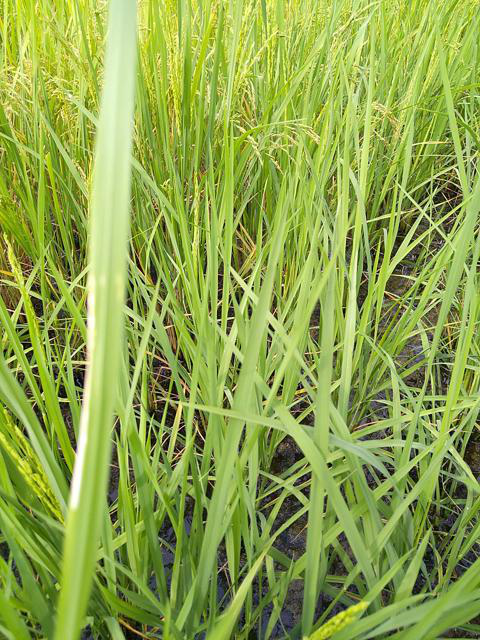

In [ ]:
# 1. Load the image
img_path = "./inputs/test_images/200001.jpg"
img = Image.open(img_path)

# 2. Resize the image to match model's expected input
MODEL_INPUT_TARGET_SIZE = (128, 128)
img_resized = img.resize(MODEL_INPUT_TARGET_SIZE)

# 3. Convert image to numpy array and normalize pixel values
img_array = np.array(img_resized) / 255.0  # Normalize to [0,1]

# 4. Add batch dimension (model expects shape [batch_size, height, width, channels])
img_array = np.expand_dims(img_array, axis=0)

# 5. Check the shape to ensure it matches the model's input
print("Input shape:", img_array.shape)  # Should be (1, 128, 128, 3)

# 6. Now predict with the model
raw_pre = loaded_best_model.predict(img_array)

# 7. Process the predictions
print("Shape of raw_predictions:", raw_pre.shape)
print("Raw prediction output (scores for each class):", raw_pre[0])

predicted_class_index = np.argmax(raw_pre[0])
confidence_score = raw_pre[0][predicted_class_index]

print(f"Predicted Class Index: {predicted_class_index}")
print(f"Confidence Score: {confidence_score:.4f}")

# 8. If you have class names, you can show the predicted class name
# classes = ["ADT45", "IR20", "KarnatakaPonni", ...]  # Replace with your class names
# predicted_class = classes[predicted_class_index]
# print(f"Predicted Class: {predicted_class}")
img